In [9]:
import pandas as pd
import numpy as np
import glob
import pickle
from rfcm import RFCM
import itertools
from multiprocessing import Process, Queue
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt

In [1]:
class TimeSeries:
    def __init__(self, data: list):
        self.data = np.array(data)
    
    def __add__(self, other):
        if isinstance(other, TimeSeries):
            return TimeSeries(self.data + other.data)
        elif isinstance(other, int):
            return TimeSeries(self.data + other)
        elif isinstance(other, float):
            return TimeSeries(self.data + other)
        elif isinstance(other, np.ndarray):
            return TimeSeries(self.data + other)
        
    def __radd__(self, other):
        return self + other
        
    def __sub__(self, other):
        if isinstance(other, TimeSeries):
            return TimeSeries(self.data - other.data)
        elif isinstance(other, int):
            return TimeSeries(self.data - other)
        elif isinstance(other, float):
            return TimeSeries(self.data - other)
        elif isinstance(other, np.ndarray):
            return TimeSeries(self.data - other)
    
    def __rsub__(self, other):
        return -self + other
    
    def __mul__(self, other):
        if isinstance(other, TimeSeries):
            return TimeSeries(self.data * other.data)
        elif isinstance(other, int):
            return TimeSeries(self.data * other)
        elif isinstance(other, float):
            return TimeSeries(self.data * other)
        elif isinstance(other, np.ndarray):
            return TimeSeries(self.data * other)
    
    def __rmul__(self, other):
        return self * other
        
    def __truediv__(self, other):
        if isinstance(other, TimeSeries):
            return TimeSeries(self.data / other.data)
        elif isinstance(other, int):
            return TimeSeries(self.data / other)
        elif isinstance(other, float):
            return TimeSeries(self.data / other)
        elif isinstance(other, np.ndarray):
            return TimeSeries(self.data / other)
    
    def __floordiv__(self, other):
        if isinstance(other, TimeSeries):
            return TimeSeries(self.data // other.data)
        elif isinstance(other, int):
            return TimeSeries(self.data // other)
        elif isinstance(other, float):
            return TimeSeries(self.data // other)
        elif isinstance(other, np.ndarray):
            return TimeSeries(self.data // other)
        
    def __pow__(self, other):
        if isinstance(other, TimeSeries):
            return TimeSeries(self.data ** other.data)
        elif isinstance(other, int):
            return TimeSeries(self.data ** other)
        elif isinstance(other, float):
            return TimeSeries(self.data ** other)
        elif isinstance(other, np.ndarray):
            return TimeSeries(self.data ** other)
    
    def __neg__(self):
        return TimeSeries(-self.data)
    
    def __repr__(self):
        return str(self.data)
    
    def __len__(self):
        return len(self.data)
    
    def append(self, other):
        self.data = np.append(self.data, other)
        return self
    
    def extend(self, other):
        self.data = np.append(self.data, other.data)
        return self
    
    def size(self):
        return len(self.data)
    
    def get_data(self):
        return self.data

### 資料切分成不同時間段

In [ ]:
# # Load the data
# df = pd.read_csv('20210103.csv')
# df = df[:df[df["ts"] == "Summary"].index.item()]

In [ ]:
# for i in range(15 * 60 // 15):
#     temp = df[(df["ts"] >= "2021-01-03T13:{:02}:{:02}".format(i * 15 // 60, i * 15 % 60)) & (df["ts"] < "2021-01-03T13:{:02}:{:02}".format((i + 1) * 15 // 60, (i + 1) * 15 % 60))]
#     temp.to_csv("20210103_{:02}_{:02}.csv".format(i * 15 // 60, i * 15 % 60))

### 製作個時間段特徵資料

In [ ]:
# Load the data
for filename in ["20210103_12_15.csv", "20210103_12_30.csv", "20210103_12_45.csv", "20210103_13_00.csv", "20210103_13_15.csv", "20210103_13_30.csv", "20210103_13_45.csv", "20210103_14_00.csv", "20210103_14_15.csv", "20210103_14_30.csv", "20210103_14_45.csv"]:
# filename = "data/20210103_00_00.csv"
    filename = "data/" + filename
    df = pd.read_csv(filename)
    print("Loaded {}".format(filename))
    features = pd.DataFrame(columns=["sa", "nSrcLink", "nDstLink", "nSrcPort", "nDstPort", "nInPkt", "nInByte", "nOutPkt", "nOutByte"])
    for sa in df["sa"].unique():
        feature = [sa]
        feature.append(len(df[df["da"] == sa]["sa"].unique()))
        feature.append(len(df[df["sa"] == sa]["da"].unique()))
        feature.append(len(df[df["sa"] == sa]["sp"].unique()))
        feature.append(len(df[df["da"] == sa]["dp"].unique()))
        feature.append(df[df["sa"] == sa]["ipkt"].sum())
        feature.append(df[df["sa"] == sa]["ibyt"].sum())
        feature.append(df[df["sa"] == sa]["opkt"].sum())
        feature.append(df[df["sa"] == sa]["obyt"].sum())
        features.loc[len(features)] = feature
    print("Features: {}".format(features.columns))
    features.to_csv(filename.replace("data", "features"))
    print("Saved {}".format(filename.replace("data", "features")))

# nSrcLink	Number of source IP connected
# nDstLink	Number of destination IP connected
# nSrcPort	Number of port connected as source
# nDstPort	Number of port connected as destination
# nInPkt	Number of packets received
# nInByte	Number of bytes received
# nOutPkt	Number of packets sent
# nOutByte	Number of bytes sent

### 形成時間序列資料

In [ ]:
merged = pd.DataFrame()
features = ["nSrcLink", "nDstLink", "nSrcPort", "nDstPort", "nInPkt", "nInByte", "nOutPkt", "nOutByte"]
counter = 0
for filename in glob.glob("features/*.csv"):
    df = pd.read_csv(filename)
    df.drop(["Unnamed: 0"], axis=1, inplace=True)
    for feature in features:
        df[feature] = df[feature].apply(lambda x: TimeSeries([x]))
    if counter == 0:
        counter += 1
        merged = df
    else:
        counter += 1
        for prefix in features:
            temp = pd.merge(merged[["sa", prefix]], df[["sa", prefix]], on='sa', how='outer').fillna(TimeSeries([0]))
            merged[prefix] = temp.apply(lambda x: x[prefix + "_x"].extend(x[prefix + "_y"]), axis=1)
            merged[prefix] = merged[prefix].apply(lambda x: TimeSeries([0] * (counter - x.size())).extend(x))
with open("features/merged.pickle", "wb") as f:
    pickle.dump(merged, f)
    print("Saved features/merged.pickle")

### 總之先跑跑看 RFCM

In [ ]:
features = ["nSrcLink", "nDstLink", "nSrcPort", "nDstPort", "nInPkt", "nInByte", "nOutPkt", "nOutByte"]
# features = ["nSrcLink", "nDstLink", "nPkt", "nByte"]
p = []
q = Queue()
max_job = 4
for i in range(2, 21):
    if len(p) < max_job:
        p.append(Process(target=labeling, args=(i, q)))
        p[-1].start()    
    else:
        p[0].join()
        merged[f"label_{i}"] = q.get()
        del p[0]
for i in range(0, len(p)):
    p[i].join()
    merged[f"label_{i + 2}"] = q.get()
    # try:
    #     with open("features/merged.pickle", "rb") as f:
    #         merged = pickle.load(f)
    #     # merged["nPkt"] = merged["nInPkt"] + merged["nOutPkt"]
    #     # merged["nByte"] = merged["nInByte"] + merged["nOutByte"]
    #     # for feature in itertools.combinations(features, 2):
    #     model = RFCM(n_clusters=i)
    #     model.fit(merged[features].to_numpy())
    #     merged[f"label_{i}"] = model.labels_
    # except Exception as e:
    #     print(e)
    #     continue
with open(f"features/labeled_all_merged.pickle", "wb") as f:
    pickle.dump(merged, f)
    print(f"Saved features/labeled_all_merged.pickle")
pure_label = pd.concat([merged[["sa"]], merged.filter(regex="^label", axis=1)], axis=1)
pure_label.to_csv(f"features/labeled_all_merged.csv")
print(f"Saved features/labeled_all_merged.csv")

In [ ]:
def labeling(i, q):
    try:
        with open("features/merged.pickle", "rb") as f:
            merged = pickle.load(f)
        model = RFCM(n_clusters=i)
        model.fit(merged[features].to_numpy())
        q.put(model.labels_)
    except Exception as e:
        print(e)

features = ["nSrcLink", "nDstLink", "nSrcPort", "nDstPort", "nInPkt", "nInByte", "nOutPkt", "nOutByte"]
# features = ["nSrcLink", "nDstLink", "nPkt", "nByte"]
p = []
q = Queue()
max_job = 4
with open("features/merged.pickle", "rb") as f:
    merged = pickle.load(f)
for i in range(2, 21):
    print(f"Start labeling {i} clusters")
    try:
        model = RFCM(n_clusters=i)
        model.fit(merged[features].to_numpy())
        merged[f"label_{i}"] = model.labels_
    except Exception as e:
        print(e)
#     if len(p) < max_job:
#         p.append(Process(target=labeling, args=(i, q)))
#         p[-1].start()
#         print(f"Labeling {i} cluster")
#     else:
#         p[0].join()
#         merged[f"label_{i - max_job}"] = q.get()
#         del p[0]
#         print(f"Labeling {i - max_job} cluster done")
# for i in range(0, len(p)):
#     p[i].join()
#     merged[f"label_{21 - len(p) + i}"] = q.get()
#     print(f"Labeling {21 - len(p) + i} cluster done")
    # try:
    #     with open("features/merged.pickle", "rb") as f:
    #         merged = pickle.load(f)
    #     # merged["nPkt"] = merged["nInPkt"] + merged["nOutPkt"]
    #     # merged["nByte"] = merged["nInByte"] + merged["nOutByte"]
    #     # for feature in itertools.combinations(features, 2):
    #     model = RFCM(n_clusters=i)
    #     model.fit(merged[features].to_numpy())
    #     merged[f"label_{i}"] = model.labels_
    # except Exception as e:
    #     print(e)
    #     continue
with open(f"features/labeled_all_merged.pickle", "wb") as f:
    pickle.dump(merged, f)
    print(f"Saved features/labeled_all_merged.pickle")
pure_label = pd.concat([merged[["sa"]], merged.filter(regex="^label", axis=1)], axis=1)
pure_label.to_csv(f"features/labeled_all_merged.csv")
print(f"Saved features/labeled_all_merged.csv")

### 聚類分析一下

In [6]:
df = pure_label.set_index("sa")

In [ ]:
def intersection(a, b):
    return (a == b).sum() / a.size

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

similarity_matrix = df.T.corr(method=intersection)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(similarity_matrix)

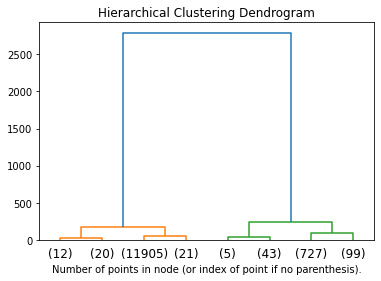

In [ ]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=2)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### 試試不切割特徵分群

In [12]:
for i in range(2, 10):
    print(f"Labeling {i} clusters")
    model = AgglomerativeClustering(distance_threshold=None, n_clusters=i)
    model.fit(similarity_matrix)
    pure_label[f"similarity_{i}"] = model.labels_
pure_label.to_csv("features/labeled_all_merged_similarity.csv")    

Labeling 2 clusters
Labeling 3 clusters
Labeling 4 clusters
Labeling 5 clusters
Labeling 6 clusters
Labeling 7 clusters
Labeling 8 clusters
Labeling 9 clusters


### 觀察分群結果

In [13]:
similarity_label = pure_label.set_index("sa").filter(regex="^similarity", axis=1)

In [17]:
similarity_label[["similarity_2"]].value_counts()

similarity_2
1               11958
0                 874
dtype: int64

In [18]:
similarity_label[["similarity_2", "similarity_3"]].value_counts()

similarity_2  similarity_3
1             0               11958
0             1                 826
              2                  48
dtype: int64

In [16]:
similarity_label[["similarity_2", "similarity_3", "similarity_4"]].value_counts()

similarity_2  similarity_3  similarity_4
1             0             1               11926
0             1             0                 826
              2             2                  48
1             0             3                  32
dtype: int64

In [19]:
similarity_label[["similarity_2", "similarity_3", "similarity_4", "similarity_5"]].value_counts()

similarity_2  similarity_3  similarity_4  similarity_5
1             0             1             0               11926
0             1             0             4                 727
                                          1                  99
              2             2             2                  48
1             0             3             3                  32
dtype: int64

In [20]:
similarity_label[["similarity_2", "similarity_3", "similarity_4", "similarity_5", "similarity_6"]].value_counts()

similarity_2  similarity_3  similarity_4  similarity_5  similarity_6
1             0             1             0             5               11905
0             1             0             4             4                 727
                                          1             1                  99
              2             2             2             0                  48
1             0             3             3             3                  32
                            1             0             2                  21
dtype: int64

In [21]:
similarity_label[["similarity_2", "similarity_3", "similarity_4", "similarity_5", "similarity_6", "similarity_7"]].value_counts()

similarity_2  similarity_3  similarity_4  similarity_5  similarity_6  similarity_7
1             0             1             0             5             5               11905
0             1             0             4             4             4                 727
                                          1             1             0                  99
              2             2             2             0             3                  43
1             0             3             3             3             1                  32
                            1             0             2             2                  21
0             2             2             2             0             6                   5
dtype: int64

In [22]:
similarity_label[["similarity_2", "similarity_3", "similarity_4", "similarity_5", "similarity_6", "similarity_7", "similarity_8"]].value_counts()

similarity_2  similarity_3  similarity_4  similarity_5  similarity_6  similarity_7  similarity_8
1             0             1             0             5             5             5               11905
0             1             0             4             4             4             4                 727
                                          1             1             0             7                  81
              2             2             2             0             3             3                  43
1             0             3             3             3             1             0                  32
                            1             0             2             2             2                  21
0             1             0             1             1             0             1                  18
              2             2             2             0             6             6                   5
dtype: int64

In [23]:
similarity_label[["similarity_2", "similarity_3", "similarity_4", "similarity_5", "similarity_6", "similarity_7", "similarity_8", "similarity_9"]].value_counts()

similarity_2  similarity_3  similarity_4  similarity_5  similarity_6  similarity_7  similarity_8  similarity_9
1             0             1             0             5             5             5             5               11905
0             1             0             4             4             4             4             4                 727
                                          1             1             0             7             7                  81
              2             2             2             0             3             3             3                  43
1             0             1             0             2             2             2             0                  21
                            3             3             3             1             0             2                  20
0             1             0             1             1             0             1             1                  18
1             0             3             3      

In [25]:
similarity_label.query("similarity_2 == 0 and similarity_3 == 2 and similarity_4 == 2 and similarity_5 == 2 and similarity_6 == 0 and similarity_7 == 6 and similarity_8 == 6 and similarity_9 == 6")

,similarity_2,similarity_3,similarity_4,similarity_5,similarity_6,similarity_7,similarity_8,similarity_9
sa,,,,,,,,
117.130.35.63,0,2,2,2,0,6,6,6
104.222.115.226,0,2,2,2,0,6,6,6
165.252.83.4,0,2,2,2,0,6,6,6
2001:7a10:3306:f5d:3a6c:907c:7f71:914b,0,2,2,2,0,6,6,6
203.178.144.169,0,2,2,2,0,6,6,6


In [ ]:
similarity_label = similarity_label.reset_index()

In [71]:
target = pd.read_csv("20210103_anomalous_suspicious.csv")

In [72]:
only_anomalous = target[target["nbDetectors"] == "anomalous"]

In [90]:
pure_label["label_5"].value_counts()

1    11929
4      847
0       55
2        1
Name: label_5, dtype: int64

In [76]:
pure_label[pure_label["sa"].isin(only_anomalous["srcIP"])].filter(regex="^label", axis=1).value_counts()

label_2  label_3  label_4  label_5  label_6  label_7  label_8  label_9  label_10  label_11  label_12  label_13  label_14  label_15  label_16  label_17  label_18  label_19  label_20
0        0        0        1        0        6        0        0        8         0         0         4         3         0         0         1         15        10        7           25
                           0        0        0        0        0        0         0         0         0         0         0         0         0         0         0         0           11
1        0        0        4        0        2        7        0        5         10        0         3         0         0         0         3         2         2         15           1
dtype: int64

In [34]:
similarity_label.query("similarity_3 == 2 and similarity_4 == 2 and similarity_5 == 2 and similarity_6 == 0 and similarity_7 == 3 and similarity_8 == 3 and similarity_9 == 3")

,index,sa,similarity_2,similarity_3,similarity_4,similarity_5,similarity_6,similarity_7,similarity_8,similarity_9
2,2,203.178.159.82,0,2,2,2,0,3,3,3
19,19,2001:7238:3c7e:360c:203d:fec0:103b:e2fd,0,2,2,2,0,3,3,3
36,36,163.218.200.195,0,2,2,2,0,3,3,3
43,43,203.178.159.86,0,2,2,2,0,3,3,3
47,47,203.178.149.157,0,2,2,2,0,3,3,3
147,147,133.83.165.71,0,2,2,2,0,3,3,3
214,214,133.83.164.151,0,2,2,2,0,3,3,3
277,277,117.229.76.204,0,2,2,2,0,3,3,3
309,309,2001:723d:c076:f04:623c:3100:9fd:dc5c,0,2,2,2,0,3,3,3
327,327,23.144.138.227,0,2,2,2,0,3,3,3


### 試試切割特徵的排列組合分群結果

In [93]:
label_16 = pd.read_csv("features/labeled_16_merged.csv", index_col=0)
label_16.set_index("sa").value_counts()

label_nSrcLink_nDstLink  label_nSrcLink_nPkt  label_nSrcLink_nByte  label_nDstLink_nPkt  label_nDstLink_nByte  label_nPkt_nByte
10                       10                   10                    10                   10                    10                  11825
7                        7                    7                     7                    7                     7                     657
6                        6                    6                     6                    6                     6                     217
0                        0                    0                     0                    0                     0                      76
11                       11                   11                    11                   11                    11                     57
dtype: int64

In [94]:
label_16[label_16["sa"].isin(only_anomalous["srcIP"])].filter(regex="^label", axis=1).value_counts()

label_nSrcLink_nDstLink  label_nSrcLink_nPkt  label_nSrcLink_nByte  label_nDstLink_nPkt  label_nDstLink_nByte  label_nPkt_nByte
10                       10                   10                    10                   10                    10                  25
0                        0                    0                     0                    0                     0                   11
7                        7                    7                     7                    7                     7                    1
dtype: int64

In [95]:
label_11 = pd.read_csv("features/labeled_11_merged.csv", index_col=0)
label_11.set_index("sa").value_counts()

label_nSrcLink_nDstLink  label_nSrcLink_nPkt  label_nSrcLink_nByte  label_nDstLink_nPkt  label_nDstLink_nByte  label_nPkt_nByte
1                        1                    1                     1                    1                     1                   11945
3                        3                    3                     3                    3                     3                     826
0                        0                    0                     0                    0                     0                      49
5                        5                    5                     5                    5                     5                      12
dtype: int64

In [96]:
label_11[label_11["sa"].isin(only_anomalous["srcIP"])].filter(regex="^label", axis=1).value_counts()

label_nSrcLink_nDstLink  label_nSrcLink_nPkt  label_nSrcLink_nByte  label_nDstLink_nPkt  label_nDstLink_nByte  label_nPkt_nByte
1                        1                    1                     1                    1                     1                   25
0                        0                    0                     0                    0                     0                   11
3                        3                    3                     3                    3                     3                    1
dtype: int64

In [98]:
label_10 = pd.read_csv("features/labeled_10_merged.csv", index_col=0)
label_10.set_index("sa").value_counts()

label_nSrcLink_nDstLink  label_nSrcLink_nPkt  label_nSrcLink_nByte  label_nDstLink_nPkt  label_nDstLink_nByte  label_nPkt_nByte
9                        9                    9                     9                    9                     9                   10927
5                        5                    5                     5                    5                     5                    1063
6                        6                    6                     6                    6                     6                     786
0                        0                    0                     0                    0                     0                      55
4                        4                    4                     4                    4                     4                       1
dtype: int64

In [99]:
label_10[label_10["sa"].isin(only_anomalous["srcIP"])].filter(regex="^label", axis=1).value_counts()

label_nSrcLink_nDstLink  label_nSrcLink_nPkt  label_nSrcLink_nByte  label_nDstLink_nPkt  label_nDstLink_nByte  label_nPkt_nByte
9                        9                    9                     9                    9                     9                   25
0                        0                    0                     0                    0                     0                   11
6                        6                    6                     6                    6                     6                    1
dtype: int64

In [100]:
label_8 = pd.read_csv("features/labeled_8_merged.csv", index_col=0)
label_8.set_index("sa").value_counts()

label_nSrcLink_nDstLink  label_nSrcLink_nPkt  label_nSrcLink_nByte  label_nDstLink_nPkt  label_nDstLink_nByte  label_nPkt_nByte
1                        1                    1                     1                    1                     1                   11889
6                        6                    6                     6                    6                     6                     772
5                        5                    5                     5                    5                     5                     114
0                        0                    0                     0                    0                     0                      57
dtype: int64

In [101]:
label_8[label_8["sa"].isin(only_anomalous["srcIP"])].filter(regex="^label", axis=1).value_counts()

label_nSrcLink_nDstLink  label_nSrcLink_nPkt  label_nSrcLink_nByte  label_nDstLink_nPkt  label_nDstLink_nByte  label_nPkt_nByte
1                        1                    1                     1                    1                     1                   25
0                        0                    0                     0                    0                     0                   11
6                        6                    6                     6                    6                     6                    1
dtype: int64

In [102]:
label_7 = pd.read_csv("features/labeled_7_merged.csv", index_col=0)
label_7.set_index("sa").value_counts()

label_nSrcLink_nDstLink  label_nSrcLink_nPkt  label_nSrcLink_nByte  label_nDstLink_nPkt  label_nDstLink_nByte  label_nPkt_nByte
5                        5                    5                     5                    5                     5                   11545
3                        3                    3                     3                    3                     3                     965
1                        1                    1                     1                    1                     1                     163
4                        4                    4                     4                    4                     4                      89
0                        0                    0                     0                    0                     0                      59
6                        6                    6                     6                    6                     6                      11
dtype: int64

In [103]:
label_7[label_7["sa"].isin(only_anomalous["srcIP"])].filter(regex="^label", axis=1).value_counts()

label_nSrcLink_nDstLink  label_nSrcLink_nPkt  label_nSrcLink_nByte  label_nDstLink_nPkt  label_nDstLink_nByte  label_nPkt_nByte
5                        5                    5                     5                    5                     5                   25
0                        0                    0                     0                    0                     0                   11
3                        3                    3                     3                    3                     3                    1
dtype: int64

In [104]:
label_6 = pd.read_csv("features/labeled_6_merged.csv", index_col=0)
label_6.set_index("sa").value_counts()

label_nSrcLink_nDstLink  label_nSrcLink_nPkt  label_nSrcLink_nByte  label_nDstLink_nPkt  label_nDstLink_nByte  label_nPkt_nByte
5                        5                    5                     5                    5                     5                   11966
3                        3                    3                     3                    3                     3                     826
0                        0                    0                     0                    0                     0                      38
2                        2                    2                     2                    2                     2                       2
dtype: int64

In [105]:
label_6[label_6["sa"].isin(only_anomalous["srcIP"])].filter(regex="^label", axis=1).value_counts()

label_nSrcLink_nDstLink  label_nSrcLink_nPkt  label_nSrcLink_nByte  label_nDstLink_nPkt  label_nDstLink_nByte  label_nPkt_nByte
5                        5                    5                     5                    5                     5                   25
0                        0                    0                     0                    0                     0                   11
3                        3                    3                     3                    3                     3                    1
dtype: int64

In [106]:
label_3 = pd.read_csv("features/labeled_3_merged.csv", index_col=0)
label_3.set_index("sa").value_counts()

label_nSrcLink_nDstLink  label_nSrcLink_nPkt  label_nSrcLink_nByte  label_nDstLink_nPkt  label_nDstLink_nByte  label_nPkt_nByte
1                        1                    1                     1                    1                     1                   11977
0                        0                    0                     0                    0                     0                     855
dtype: int64

In [107]:
label_3[label_3["sa"].isin(only_anomalous["srcIP"])].filter(regex="^label", axis=1).value_counts()

label_nSrcLink_nDstLink  label_nSrcLink_nPkt  label_nSrcLink_nByte  label_nDstLink_nPkt  label_nDstLink_nByte  label_nPkt_nByte
1                        1                    1                     1                    1                     1                   26
0                        0                    0                     0                    0                     0                   11
dtype: int64

In [108]:
label_2 = pd.read_csv("features/labeled_2_merged.csv", index_col=0)
label_2.set_index("sa").value_counts()

label_nSrcLink_nDstLink  label_nSrcLink_nPkt  label_nSrcLink_nByte  label_nDstLink_nPkt  label_nDstLink_nByte  label_nPkt_nByte
0                        0                    0                     0                    0                     0                   9865
1                        1                    1                     1                    1                     1                   2967
dtype: int64

In [109]:
label_2[label_2["sa"].isin(only_anomalous["srcIP"])].filter(regex="^label", axis=1).value_counts()

label_nSrcLink_nDstLink  label_nSrcLink_nPkt  label_nSrcLink_nByte  label_nDstLink_nPkt  label_nDstLink_nByte  label_nPkt_nByte
1                        1                    1                     1                    1                     1                   24
0                        0                    0                     0                    0                     0                   13
dtype: int64